# Notebook 1 - Fuel property modeling

By Vincent Blay, July 2021

In this notebook we demonstrate the use of Macaw embeddings to describe molecules and train regression models of different molecular properties. The results illustrate the usefulness and speed of the approach and its compatibility with small and medium-sized datasets that are commonly found in the biosciences.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

import macaw_py
print(macaw_py.__version__)

from macaw_py import *
%run "./plotting.py"

0.1.7


## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [3]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


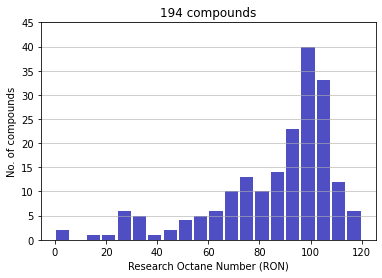

In [4]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us split the data in training and validation sets:

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

Compute the Macaw embeddings of the molecules is very easy. We just initialize the embedder:

In [6]:
mcw = Macaw()
mcw.fit(smi_train)

And then we project the training molecules:

In [7]:
X_train = mcw.transform(smi_train)
X_train[0:4]

array([[ 0.4162928 , -0.0432059 ,  0.03616732, -0.10029178,  0.03198059,
        -0.50409552, -0.20808057,  0.06853246, -0.00553805,  0.02103262,
         0.0693989 , -0.07795491, -0.01572385, -0.04499945, -0.08372352],
       [-0.08871135, -0.05778696, -0.06388243,  0.04957561,  0.11894475,
         0.01551057, -0.01311031,  0.04485449, -0.06907796, -0.09265373,
         0.08136952,  0.06112069, -0.10685916,  0.02339624, -0.1673721 ],
       [ 0.1554657 ,  0.07601255,  0.03903917, -0.06199665,  0.03841679,
        -0.15479221, -0.00861595, -0.0010705 ,  0.02617077, -0.00773999,
        -0.04750358, -0.11093811, -0.09982336,  0.02330988, -0.04815144],
       [-0.12138652,  0.18756048,  0.11116509, -0.14093599,  0.02477209,
        -0.01255888, -0.02191363, -0.07422269,  0.05605489,  0.17204782,
         0.06475297,  0.05593344,  0.07347712,  0.01983177,  0.03477524]])

The fit and transform process can be done faster in one step using the `fit_transform` method.

A variety of fingerprints (`type_fp`) and similarity metrics (`metric`) are available and can be tuned to maximize the performance of the embedding for a given problem. The dimensionality of the embedding can be set using the `n_components` argument.

As an optional parameter, the property values can also be provided when fitting the embedder (`Y=y_train`). In this case, it will choose the landmark molecules more uniformly throughout the RON range. If not provided, landmark molecules are chosen randomly.

In [8]:
mcw = Macaw(type_fp='atompairs', metric='rogot-goldberg', n_components =15)
X_train = mcw.fit_transform(smiles, n_landmarks=100, Y=y_train)
X_train[0:4]

array([[-0.19194447,  0.31579596,  0.04214355, -0.0850576 ,  0.22488615,
        -0.12085628,  0.16893778, -0.00800397,  0.09059228, -0.01190277,
         0.10143843, -0.07276786, -0.16909341,  0.18127334, -0.06519182],
       [ 0.06060485, -0.00225778,  0.14814835,  0.00394133, -0.15488413,
        -0.07997889, -0.14234461, -0.126787  ,  0.00366438, -0.13487422,
         0.18025734, -0.10482682,  0.07771261,  0.01058046,  0.06241176],
       [ 0.23325632,  0.17952541,  0.08134684,  0.01860579, -0.14485358,
         0.15597144, -0.01420982, -0.04121307, -0.03616419,  0.18435428,
        -0.03834295,  0.14467   ,  0.04207736, -0.22471439, -0.12176145],
       [-0.36164278,  0.0488255 ,  0.19767189, -0.20801826,  0.19075666,
         0.22946565, -0.20991924,  0.0721745 , -0.05080286,  0.07754886,
         0.05261159,  0.00646748,  0.02404201,  0.04267331,  0.07750195]])

In order to automate the selection of the `type_fp` and `metric`, we have implemented the function `Macaw_optimus`, which can help select a good combination. Internally, it explores a variety of embeddings by combining these hyperparameters and use them to train SVM models, which are assessed using cross_validation. The embedding leading to the best performing model is returned to the user.

In [9]:
mcw = Macaw_optimus(smi_train, y= y_train, verbose=True, C=100, n_components=20, n_landmarks=100)

Problem type identified as regression
morgan2 + tanimoto: 0.580
morgan3 + tanimoto: 0.582
rdk5 + tanimoto: 0.553
rdk7 + tanimoto: 0.567
featmorgan2 + tanimoto: 0.554
featmorgan3 + tanimoto: 0.513
maccs + tanimoto: 0.666
avalon + tanimoto: 0.612
atompairs + tanimoto: 0.695
torsion + tanimoto: 0.516
pattern + tanimoto: 0.567
secfp + tanimoto: 0.510
layered + tanimoto: 0.677
maccs + cosine: 0.674
maccs + dice: 0.649
maccs + sokal: 0.638
maccs + kulczynski: 0.675
maccs + mcconnaughey: 0.675
maccs + braun-blanquet: 0.641
maccs + rogot-goldberg: 0.654
maccs + asymmetric: 0.668
maccs + manhattan: 0.618
atompairs + cosine: 0.709
atompairs + dice: 0.714
atompairs + sokal: 0.693
atompairs + kulczynski: 0.687
atompairs + mcconnaughey: 0.687
atompairs + braun-blanquet: 0.694
atompairs + rogot-goldberg: 0.714
atompairs + asymmetric: 0.652
atompairs + manhattan: 0.661
layered + cosine: 0.689
layered + dice: 0.687
layered + sokal: 0.675
layered + kulczynski: 0.700
layered + mcconnaughey: 0.700
layere

The embeddings for any new molecules can be commputed easily: we just provide the SMILES to the `transform()` method. Let us compute the embeddings of the test set molecules.

In [10]:
X_train = mcw.transform(smi_train)
X_test = mcw.transform(smi_test)
X_test[0:4]

array([[ 1.68790180e-02,  1.09374729e-01,  2.01668034e-01,
        -1.61062918e-01,  9.63949942e-02, -2.76575424e-02,
        -3.42732981e-03, -2.38528011e-01, -1.30023986e-01,
         2.17678924e-01,  1.66359113e-01, -1.17047280e-02,
        -1.27419730e-01, -8.90083958e-02,  2.03061430e-02,
         1.67321472e-01, -1.46085583e-01,  3.09551450e-02,
        -7.86710578e-02,  1.10747051e-02],
       [-3.23650527e-01,  1.15303018e-01,  1.83489970e-02,
         3.70067295e-02, -2.24949837e-01,  2.95336125e-04,
         3.58767202e-02, -1.70537616e-01, -1.53906808e-01,
        -2.33515757e-03, -1.93266234e-02,  1.68806936e-02,
         9.14981868e-02, -9.06351874e-02, -2.62598068e-01,
        -3.96447148e-02,  1.44989007e-01,  2.47450634e-01,
         8.45392360e-02, -8.29415773e-02],
       [ 6.06331692e-02, -1.25888633e-01,  1.04565910e-01,
        -8.00233147e-02,  1.46960811e-01, -4.84275524e-02,
        -7.76439446e-02, -1.55248100e-01,  3.66162869e-02,
        -9.53834636e-02,  7.7

In [11]:
X_test.shape

(39, 20)

Now we can use the embeddings as predictors for any machine learning tool, from linear models to neural networks. In this notebook, we will mainly use Support Vector Machines (SVM) from the scikit-learn library.

As an example, here we explore a Support Vector Regressor (SVR) from the `sklearn` package.

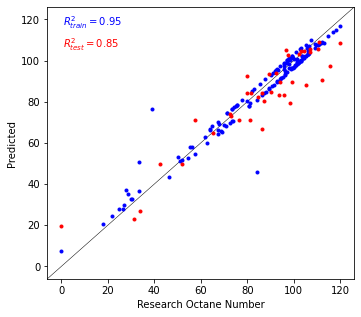

In [12]:
regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Research Octane Number", savetitle="../results/RON.png") 

As another example, we also train a relevance vector regressor (RVR) using the same Macaw features. This type of model automatically deals with the regularization and provides uncertainty estimates of the predictions. Information about this package can be found [here](https://sklearn-rvm.readthedocs.io/en/latest/index.html).

In [13]:
regr = EMRVR(kernel='rbf', gamma='scale')
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred, y_train_std = regr.predict(X_train, return_std=True)

# Test set predictions
y_test_pred, y_test_std = regr.predict(X_test, return_std=True)

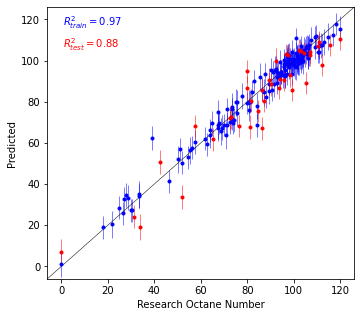

In [14]:
# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            y_train_std=y_train_std, y_test_std=y_test_std, xlabel="Research Octane Number") 

Let us save the Macaw embedder and the RON model for later use in Jupyter Notebook 3.

In [15]:
data = (mcw, regr)

picklefile = open("../results/RON_model_RVR.pickle", 'wb')
pickle.dump(data, picklefile, protocol=pickle.HIGHEST_PROTOCOL)
picklefile.close()

## Cetane Number (CN)

Here we demonstrate how Macaw embeddings can help model cetane numbers. We will use a similar approach as above. First we load the data:

In [16]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


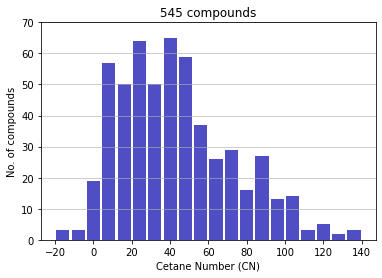

In [17]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [18]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

We compute the Macaw embeddings:

In [19]:
mcw = Macaw_optimus(smi_train, y_train, verbose=True, n_components=15, n_landmarks=100)

Problem type identified as regression
morgan2 + tanimoto: 0.604
morgan3 + tanimoto: 0.691
rdk5 + tanimoto: 0.413
rdk7 + tanimoto: 0.553
featmorgan2 + tanimoto: 0.481
featmorgan3 + tanimoto: 0.625
maccs + tanimoto: 0.529
avalon + tanimoto: 0.481
atompairs + tanimoto: 0.730
torsion + tanimoto: 0.641
pattern + tanimoto: 0.632
secfp + tanimoto: 0.581
layered + tanimoto: 0.561
torsion + cosine: 0.651
torsion + dice: 0.662
torsion + kulczynski: 0.641
torsion + mcconnaughey: 0.641
torsion + braun-blanquet: 0.654
torsion + rogot-goldberg: 0.661
torsion + asymmetric: 0.624
torsion + manhattan: 0.618
atompairs + cosine: 0.700
atompairs + dice: 0.722
atompairs + sokal: 0.718
atompairs + kulczynski: 0.705
atompairs + mcconnaughey: 0.705
atompairs + braun-blanquet: 0.721
atompairs + rogot-goldberg: 0.726
atompairs + asymmetric: 0.701
atompairs + manhattan: 0.674
morgan3 + cosine: 0.695
morgan3 + dice: 0.692
morgan3 + sokal: 0.687
morgan3 + kulczynski: 0.690
morgan3 + mcconnaughey: 0.690
morgan3 + b

Let us train a SVR model. We try different values of the regularization constant `C` to improve its performance:

In [20]:
X_train = mcw.transform(smi_train)

for C in [30,50,100,300]:
    regr = SVR(kernel='rbf', C=C, epsilon=5)
    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.7852848742047698
0.8029739834389042
0.8127592523709403
0.8096002125317503


We train the final model with the best value `C=100` and validate the model performance on the test set:

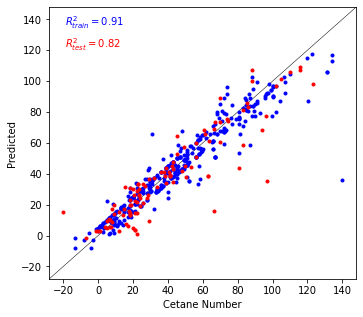

In [21]:
regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, xlabel="Cetane Number", 
            y_test=y_test_pred, savetitle="../results/CN.png") 

## Yield Sooting Index

Here we demonstrate how Macaw embeddings can help model Yield Soot Index (YSI), another complex molecular property.

In [22]:
df = pd.read_csv('../data/data_YSI.csv')
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


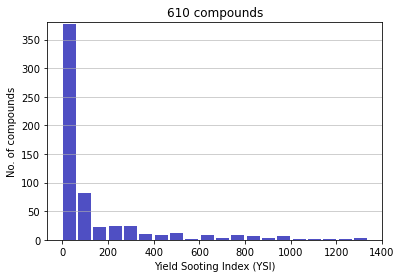

In [23]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In this case, we see that the data distribution is very skewed. There are different approaches to deal with this, for example, we could transform the YSI values to  get a more uniform distribution. For illustration purposes, we will work with the data as is.

We apply a stratified sampling to hold out the validation set in this case:

In [24]:
bins = np.linspace(min(Y), max(Y), 10+1)
Y_binned = np.digitize(Y, bins[:-1])
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42, stratify=Y_binned)

Next we compute the Macaw embeddings using only training data. In a case like this, it is recommended to provide property information (`Y=y_train`) to achieve a more balanced choice of landmarks. 

In [25]:
mcw = Macaw_optimus(smi_train, y_train)

X_train = mcw.transform(smi_train)

Problem type identified as regression
Setting recommended combination: atompairs + braun-blanquet


Since we did not transform the YSI data, we may want to introduce sample weights in the model. The way we do it here is by binning molecules as a function of YSI values, and then 
setting the weight of each datum in inverse proportion to the number of molecules in the bucket.

In [26]:
nbins = 10
leny = len(y_train)
bins = np.linspace(min(y_train), max(y_train), nbins+1)
y_binned = np.digitize(y_train, bins[:-1])
weights = [1./nbins]*leny
for i in range(leny):
    weights[i] = weights[i]/sum(y_binned==y_binned[i])
weights = np.asarray(weights)
weights = weights/weights.mean()

Now we can train the model. As in the other regression examples, we use a SVR. For this model, the weights provided will scale the regularization in different regions of space, in relation to the global regularization set by `C`.

In [27]:
for C in [30,100,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=20)
 
    scores = cross_val_score(regr, X_train, y_train, cv=5, fit_params={'sample_weight': weights})
    print(scores.mean())

0.6196931506868371
0.7470393216064493
0.7932498587714397
0.8128944368146943


And we train the final model:

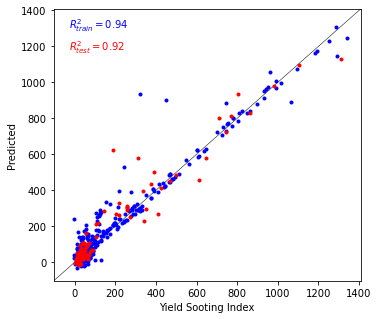

In [28]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train, sample_weight=weights)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index") 

##  Melting Point (MP)

In [9]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


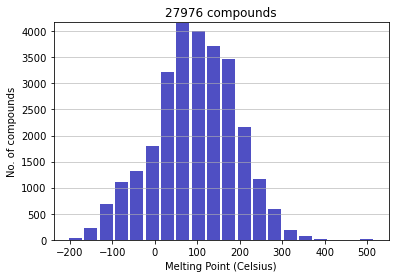

In [10]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [32]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

22380


In [33]:
mcw = Macaw_optimus(smi_train, y_train, C=50)

Problem type identified as regression
Setting recommended combination: maccs + dice


In [34]:
X_train = mcw.transform(smi_train)

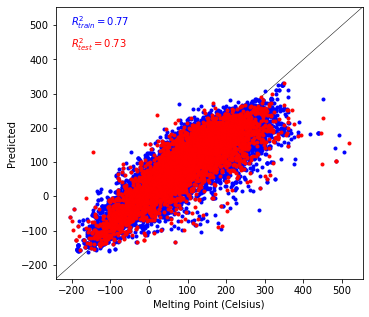

In [35]:
regr = SVR(kernel = 'rbf', C=100, epsilon = 20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="../results/MP.png") 

Macaw also allows to concatenate fingerprints, which may improve performance in some cases:

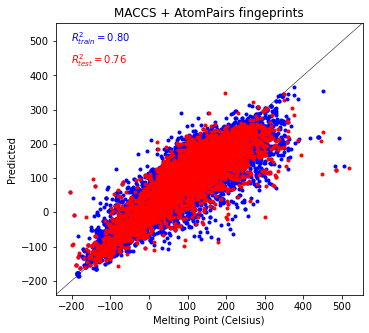

In [37]:
mcw.set_type_fp('maccs+atompairs')
mcw.set_metric('cosine')

X_train = mcw.transform(smi_train)

regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Melting Point (Celsius)", title="MACCS + AtomPairs fingeprints") 

## Flash Point (FP)

In [3]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


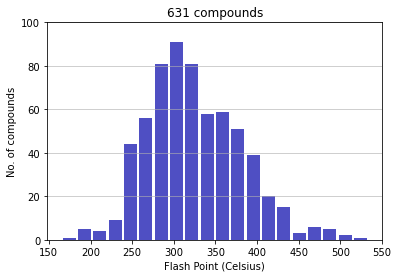

In [4]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [6]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

504


In [42]:
mcw = Macaw_optimus(smi_train, y_train, C=300)

X_train = mcw.transform(smi_train)

Problem type identified as regression
Setting recommended combination: pattern + kulczynski


In [43]:
for C in [50,100,200,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=2)

    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.8233237368920833
0.835751766697878
0.8376877559220809
0.8349551278514357
0.8253471413444498


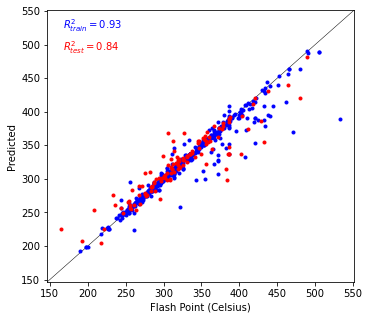

In [44]:
regr = SVR(kernel='rbf', C=300, epsilon=2)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)", savetitle="../results/FP.png") 